In [2]:
import xarray
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import glob
import os
from scipy import special
import math
from astropy.stats.circstats import circmean, circvar

/Users/jakecunningham/opt/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
def loader(path):
    paths = glob.glob(path)
    paths.sort(key=os.path.getmtime)
    file = xarray.open_mfdataset(paths, combine='by_coords')
    return file

Ue_file_old = loader('/Volumes/4YP/Data/TimeSeries/Generated/Eulerian*.nc')
Ue_file_new = loader('/Volumes/JCHD/Microplastics_Paper/Data/TimeSeries/Eulerian*.nc')
Us_file = loader('/Volumes/4YP/Data/TimeSeries/Generated/Stokes*.nc')

In [4]:
def higgins_convolution_parallel_variable_f_variable_k_equator1(Us_file,Us_u_array,Us_v_array,k_array,lat, lon, power):
    
    kernel_length = 300
    
    Ue_point = np.zeros([len(Us_u_array[:,0,0]),1,1]) + 0j
            
    kernel = np.zeros([300,1]) + 0j

    w = 7.2921 * (10**-5) * 3600
    latitude = np.linspace(-78,80,317)[lat]
    

    
    if abs(latitude) < 20:
        v = ((10**power) - (((10**power)-(10**-6))/20)*(20 - abs(latitude)))*3600          
    else:           
        v = (10**power)*3600
    
    
    latitude_rad = latitude * np.pi/180
    f = 2*w*np.sin(latitude_rad)
            
    k_point = k_array[:,lat,lon]
    k = sum(k_point) / len(k_point)
    
    D = np.sqrt((8*k*k*v)/abs(f))
    print(D)

    for n in range(300):
        if n > 0:
            t = 3*n
            K = (((2*k*(v**0.5))/((t*np.pi)**0.5)))*np.exp(-1j*f*t) - ((1j*f*np.exp(-1j*f*t)) *special.erfcx((4*k*k*v*t)**0.5))
            kernel[n-1] = K
    
    U_forcing_list = Us_u_array[:,lat,lon] + (1j * Us_v_array[:,lat,lon])
    
    if math.isnan(U_forcing_list[0]) == 0:
        U_forcing = np.reshape(U_forcing_list, (1,len(U_forcing_list)))
    
        for i in range(len(U_forcing_list)-1):
            j = i+1
            if j <= kernel_length:
                Us = U_forcing[0][:j]
                K = kernel[:j]
                Us_reverse = np.flip(Us)
                Us_vector = np.reshape(Us_reverse, (1,j))
            else:
                Us = U_forcing[0][j-kernel_length:j]
                K = kernel[:kernel_length]
                Us_reverse = np.flip(Us)
                Us_vector = np.reshape(Us_reverse, (1,kernel_length))
            matrix = np.dot(K,Us_vector)
            Ue = sum(np.diag(matrix))
            Ue_point[i+1,0,0]=Ue*3
                  
    return Ue_point

In [5]:
PF_file = loader('/Volumes/4YP/Data/TimeSeries/Raw/PFreq*.nc')
k_file = ((2*np.pi*PF_file.fp)**2)/9.81
k_array = k_file.values
print(np.nanmean(k_array))
    
Us_u_array = Us_file.uuss.values
Us_v_array = Us_file.vuss.values
time = Us_file.uuss['time'].values

0.06120992


In [6]:
Ue_three1 = higgins_convolution_parallel_variable_f_variable_k_equator1(Us_file,Us_u_array,Us_v_array,k_array,246, 290, -6)[-248:,0,0]
Ue_three2 = higgins_convolution_parallel_variable_f_variable_k_equator1(Us_file,Us_u_array,Us_v_array,k_array,96, 120, -6)[-248:,0,0]

0.011382967308578068
0.008756444038302972


/Users/jakecunningham/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


In [7]:
Usu_point1 = Us_file.uuss[:,246,290].values
Usv_point1 = Us_file.vuss[:,246,290].values
Us_point1 = Usu_point1 + (1j*Usv_point1) 

Ueu_point1_old = Ue_file_old.U[:,246,290].values
Uev_point1_old = Ue_file_old.V[:,246,290].values
Ue_1_old = Ueu_point1_old + (1j*Uev_point1_old)

Ueu_point1_new = Ue_file_new.U[:,246,290].values
Uev_point1_new = Ue_file_new.V[:,246,290].values
Ue_1_new = Ueu_point1_new + (1j*Uev_point1_new)

Ul_1_old = Us_point1 + Ue_1_old
Ul_1_new = Us_point1 + Ue_1_new

In [8]:
Usu_point2 = Us_file.uuss[:,96,120].values
Usv_point2 = Us_file.vuss[:,96,120].values
Us_point2 = Usu_point2 + (1j*Usv_point2)

Ueu_point2_old = Ue_file_old.U[:,96,120].values
Uev_point2_old = Ue_file_old.V[:,96,120].values
Ue_2_old = Ueu_point2_old + (1j*Uev_point2_old)

Ueu_point2_new = Ue_file_new.U[:,96,120].values
Uev_point2_new = Ue_file_new.V[:,96,120].values
Ue_2_new = Ueu_point2_new + (1j*Uev_point2_new)

Ul_2_old = Us_point2 + Ue_2_old
Ul_2_new = Us_point2 + Ue_2_new

In [9]:
Us_1 = Us_point1
Us_2 = Us_point2

Ue_one1 = Ue_1_old
Ue_two1 = Ue_1_new

Ue_one2 = Ue_2_old
Ue_two2 = Ue_2_new

## Magnitude Statistics

In [10]:
print(np.mean(abs(Us_1)))
print(np.mean(abs(Us_2)))

0.14651471
0.056479216


In [11]:
print(np.mean(abs(Ue_one1)))
print(np.mean(abs(Ue_two1)))
print(np.mean(abs(Ue_three1)))

0.13791604060200563
0.1447685235065239
0.5457184890224844


In [12]:
print(np.mean(abs(Ue_one2)))
print(np.mean(abs(Ue_two2)))
print(np.mean(abs(Ue_three2)))

0.052054110292454235
0.07557034111388032
0.2569776034485227


In [13]:
print(np.mean(abs(Ue_one1+Us_1)))
print(np.mean(abs(Ue_two1+Us_1)))
print(np.mean(abs(Ue_three1+Us_1)))

0.12292137730005434
0.1236041862217406
0.5277271928375281


In [14]:
print(np.mean(abs(Ue_one2+Us_2)))
print(np.mean(abs(Ue_two2+Us_2)))
print(np.mean(abs(Ue_three2+Us_2)))

0.044313575342688614
0.0633755688853035
0.2519806136996829


In [15]:
print((np.mean(abs(Ue_one1))/np.mean(abs(Us_1))-1)*100)
print((np.mean(abs(Ue_two1))/np.mean(abs(Us_1))-1)*100)
print((np.mean(abs(Ue_three1))/np.mean(abs(Us_1))-1)*100)

-5.86881204028713
-1.1918190417907093
272.46667928573754


In [16]:
print((np.mean(abs(Ue_one2))/np.mean(abs(Us_2))-1)*100)
print((np.mean(abs(Ue_two2))/np.mean(abs(Us_2))-1)*100)
print((np.mean(abs(Ue_three2))/np.mean(abs(Us_2))-1)*100)

-7.8349270271635625
33.802037230334925
354.9949935010416


In [17]:
print((np.mean(abs(Ue_one1+Us_1))/np.mean(abs(Us_1))-1)*100)
print((np.mean(abs(Ue_two1+Us_1))/np.mean(abs(Us_1))-1)*100)
print((np.mean(abs(Ue_three1+Us_1))/np.mean(abs(Us_1))-1)*100)

-16.103049214639853
-15.637014845705943
260.18716433278024


In [18]:
print((np.mean(abs(Ue_one2+Us_2))/np.mean(abs(Us_2))-1)*100)
print((np.mean(abs(Ue_two2+Us_2))/np.mean(abs(Us_2))-1)*100)
print((np.mean(abs(Ue_three2+Us_2))/np.mean(abs(Us_2))-1)*100)

-21.540030514396825
12.210426769233118
346.14750917638696


## Angle Statistics

In [19]:
def corrector(delta_L_one1):
    delta_L_one1_cor = []
    for d in delta_L_one1:
        if d < 0:
            d = d + 360
            delta_L_one1_cor.append(d)
        else:
            delta_L_one1_cor.append(d)
    return np.array(delta_L_one1_cor)

In [20]:
theta_S1 = corrector(np.angle(Us_1)*180/np.pi)
theta_S2 = corrector(np.angle(Us_2)*180/np.pi)

In [21]:
print(circmean(theta_S1*np.pi/180)*180/np.pi +360)
print(circmean(theta_S2*np.pi/180)*180/np.pi)

370.1003259382316
-111.64556219279275


In [22]:
theta_E_one1 = corrector(np.angle(Ue_one1)*180/np.pi)
theta_E_two1 = corrector(np.angle(Ue_two1)*180/np.pi)
theta_E_three1 = corrector(np.angle(Ue_three1)*180/np.pi)

In [23]:
print(circmean(theta_E_one1*np.pi/180)*180/np.pi)
print(circmean(theta_E_two1*np.pi/180)*180/np.pi)

-142.8600013848292
-155.5239776548871


In [24]:
theta_E_one2 = corrector(np.angle(Ue_one2)*180/np.pi)
theta_E_two2 = corrector(np.angle(Ue_two2)*180/np.pi)
theta_E_three2 = corrector(np.angle(Ue_three2)*180/np.pi)

In [25]:
print(circmean(theta_E_one2*np.pi/180)*180/np.pi + 360)
print(circmean(theta_E_two2*np.pi/180)*180/np.pi + 360)

373.89036242420434
383.5952160480256


In [26]:
theta_L_one1 = corrector(np.angle(Ue_one1+Us_1)*180/np.pi)
theta_L_two1 = corrector(np.angle(Ue_two1+Us_1)*180/np.pi)
theta_L_three1 = corrector(np.angle(Ue_three1+Us_1)*180/np.pi)

In [27]:
print(circmean(theta_L_one1*np.pi/180)*180/np.pi + 360)
print(circmean(theta_L_two1*np.pi/180)*180/np.pi + 360)

335.5307328249003
345.6414890133029


In [28]:
theta_L_one2 = corrector(np.angle(Ue_one2+Us_2)*180/np.pi)
theta_L_two2 = corrector(np.angle(Ue_two2+Us_2)*180/np.pi)
theta_L_three2 = corrector(np.angle(Ue_three2+Us_2)*180/np.pi)

In [29]:
print(circmean(theta_L_one2*np.pi/180)*180/np.pi + 360)
print(circmean(theta_L_two2*np.pi/180)*180/np.pi + 360)

266.4079209376231
326.6507172500432


In [30]:
delta_E_one1 = corrector(theta_S1-theta_E_one1)
delta_E_two1 = corrector(theta_S1-theta_E_two1)
delta_E_three1 = corrector(theta_S1-theta_E_three1)

In [31]:
print(circmean(delta_E_one1*np.pi/180)*180/np.pi)
print(circmean(delta_E_two1*np.pi/180)*180/np.pi)

150.4728640926469
162.68258638154882


In [32]:
print(circvar(delta_E_one1*np.pi/180)*180/np.pi)
print(circvar(delta_E_two1*np.pi/180)*180/np.pi)

22.174175740550492
25.127502410843046


In [33]:
delta_E_one2 = corrector(theta_S2-theta_E_one2)
delta_E_two2 = corrector(theta_S2-theta_E_two2)
delta_E_three2 = corrector(theta_S2-theta_E_three2)

In [34]:
print(circmean(delta_E_one2*np.pi/180)*180/np.pi)
print(circmean(delta_E_two2*np.pi/180)*180/np.pi)

-154.48125074843458
179.1882268548917


In [35]:
print(circvar(delta_E_one2*np.pi/180)*180/np.pi)
print(circvar(delta_E_two2*np.pi/180)*180/np.pi)

18.511289797708514
29.01420622237205


In [36]:
delta_L_one1 = corrector(theta_S1-theta_L_one1)
delta_L_two1 = corrector(theta_S1-theta_L_two1)
delta_L_three1 = corrector(theta_S1-theta_L_three1)

In [37]:
delta_L_one2 = corrector(theta_S2-theta_L_one2)
delta_L_two2 = corrector(theta_S2-theta_L_two2)
delta_L_three2 = corrector(theta_S2-theta_L_three2)

In [38]:
def angular_mean_complex(delta):
    delta = delta * np.pi / 180
    r_delta = np.cos(delta)
    i_delta = np.sin(delta)
    r_mean = np.mean(r_delta)
    i_mean = np.mean(i_delta)
    radius = np.sqrt(r_mean**2 + i_mean**2)
    theta_r = np.arccos(r_mean/radius)*180/np.pi
    theta_i = np.arcsin(i_mean/radius)*180/np.pi
    print('Theta =',theta_i,r_mean,i_mean)

In [39]:
angular_mean_complex(delta_L_one1)
angular_mean_complex(delta_L_two1)

Theta = 40.349148009711 0.3736762638693142 0.3174519895400318
Theta = 31.93758476729406 0.2925856559670564 0.18238493064550104


In [40]:
angular_mean_complex(delta_L_one2)
angular_mean_complex(delta_L_two2)

Theta = -42.3972737889358 0.3482255192838797 -0.3179432115851076
Theta = -0.6677535018232826 0.07518679981025962 -0.0008763040234529383


In [41]:
print(circmean(delta_L_one1*np.pi/180)*180/np.pi)
print(circmean(delta_L_two1*np.pi/180)*180/np.pi)

40.349148009711
31.93758476729405


In [42]:
print('Circular variance =',circvar(delta_L_one1*np.pi/180)*180/np.pi)
print('Circular variance =',circvar(delta_L_two1*np.pi/180)*180/np.pi)

Circular variance = 29.202745825502944
Circular variance = 37.54155830026305


In [43]:
print('Circular variance =',circvar(delta_L_one2*np.pi/180)*180/np.pi)
print('Circular variance =',circvar(delta_L_two2*np.pi/180)*180/np.pi)

Circular variance = 30.27859286246929
Circular variance = 52.98760062800755


In [44]:
print(np.mean(delta_L_one1))
print(np.mean(delta_L_two1))

138.27029042882432
158.67645249975672


In [45]:
print(np.mean(delta_L_one2))
print(np.mean(delta_L_two2))

220.21927967824092
179.13866112508146


In [46]:
a , b = np.histogram(delta_L_one1, bins=np.arange(-5, 360+bin_size, bin_size))
print(b[np.argmax(a)])

a , b = np.histogram(delta_L_two1, bins=np.arange(-5, 360+bin_size, bin_size))
print(b[np.argmax(a)])

a , b = np.histogram(delta_L_three1, bins=np.arange(-5, 360+bin_size, bin_size))
print(b[np.argmax(a)])

15
15
245


In [47]:
a , b = np.histogram(delta_L_one2, bins=np.arange(-5, 360+bin_size, bin_size))
print(b[np.argmax(a)])

a , b = np.histogram(delta_L_two2, bins=np.arange(-5, 360+bin_size, bin_size))
print(b[np.argmax(a)])

a , b = np.histogram(delta_L_three2, bins=np.arange(-5, 360+bin_size, bin_size))
print(b[np.argmax(a)])

285
15
85


In [48]:
print(np.std(delta_L_one1))
print(np.std(delta_L_two1))
print(np.std(delta_L_three1))

118.20828878694482
119.26211100325276
104.84986745144168


In [49]:
print(np.std(delta_L_one2))
print(np.std(delta_L_two2))
print(np.std(delta_L_three2))

117.12926224698128
108.23906472590578
103.68982494200523


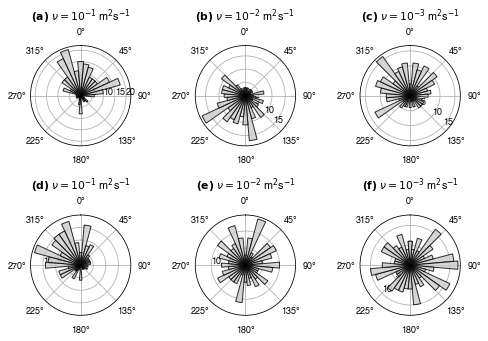

In [50]:
bin_size = 10

fig = plt.figure(figsize=(7,14))

font = {'family':'sans-serif',
        'sans-serif':['Helvetica'],
        'weight' : 'normal',
        'size'   : 9}

matplotlib.rc('font', **font)
plt.rc('axes', axisbelow=True)

ax1 = fig.add_subplot(631, projection='polar')
a , b = np.histogram(theta_S1, bins=np.arange(-5, 360+bin_size, bin_size))
centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
ax1.bar(centers, a, width=np.deg2rad(bin_size), bottom=0.0, alpha=0.8, color='0.8', edgecolor='k',label=r'$\nu=10^{-1}$')
ax1.set_theta_zero_location("N")
ax1.set_theta_direction(-1)
ax1.set_title(r'$\bf{(a)}$ $\nu=10^{-1}$ m$^{2}$s$^{-1}$',y=1.2)
ax1.set_rlabel_position(90)
ax1.grid(zorder=3)

ax1 = fig.add_subplot(632, projection='polar')
a , b = np.histogram(theta_E_one1, bins=np.arange(-5, 360+bin_size, bin_size))
centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
ax1.bar(centers, a, width=np.deg2rad(bin_size), bottom=0.0, alpha=0.8,color='0.8', edgecolor='k',label=r'$\nu=10^{-2}$')
ax1.set_theta_zero_location("N")
ax1.set_theta_direction(-1)
ax1.set_title(r'$\bf{(b)}$ $\nu=10^{-2}$ m$^{2}$s$^{-1}$',y=1.2)
ax1.set_rlabel_position(135)
ax1.grid(zorder=3)

ax1 = fig.add_subplot(633, projection='polar')
a , b = np.histogram(theta_L_one1, bins=np.arange(-5, 360+bin_size, bin_size))
centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
ax1.bar(centers, a, width=np.deg2rad(bin_size), bottom=0.0, alpha=0.8,color='0.8', edgecolor='k',label=r'$\nu=10^{-3}$')
ax1.set_theta_zero_location("N")
ax1.set_theta_direction(-1)
ax1.set_title(r'$\bf{(c)}$ $\nu=10^{-3}$ m$^{2}$s$^{-1}$',y=1.2)
ax1.set_rlabel_position(133)
ax1.grid(zorder=3)

ax1 = fig.add_subplot(634, projection='polar')
a , b = np.histogram(delta_L_one2, bins=np.arange(-5, 360+bin_size, bin_size))
centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
ax1.bar(centers, a, width=np.deg2rad(bin_size), bottom=0.0, alpha=0.8,color='0.8', edgecolor='k')
ax1.set_theta_zero_location("N")
ax1.set_theta_direction(-1)
ax1.set_title(r'$\bf{(d)}$ $\nu=10^{-1}$ m$^{2}$s$^{-1}$',y=1.2)
ax1.set_rlabel_position(270)
ax1.xaxis.get_label().set_zorder(3)

ax1 = fig.add_subplot(635, projection='polar')
a , b = np.histogram(delta_L_two2, bins=np.arange(-5, 360+bin_size, bin_size))
centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
ax1.bar(centers, a, width=np.deg2rad(bin_size), bottom=0.0, alpha=0.8,color='0.8', edgecolor='k')
ax1.set_theta_zero_location("N")
ax1.set_theta_direction(-1)
ax1.set_title(r'$\bf{(e)}$ $\nu=10^{-2}$ m$^{2}$s$^{-1}$',y=1.2)
ax1.set_rlabel_position(270)

ax1 = fig.add_subplot(636, projection='polar')
a , b = np.histogram(delta_L_three2, bins=np.arange(-5, 360+bin_size, bin_size))
centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
ax1.bar(centers, a, width=np.deg2rad(bin_size), bottom=0.0, alpha=0.8,color='0.8', edgecolor='k')
ax1.set_theta_zero_location("N")
ax1.set_theta_direction(-1)
ax1.set_title(r'$\bf{(f)}$ $\nu=10^{-3}$ m$^{2}$s$^{-1}$',y=1.2)
ax1.set_rlabel_position(225)

plt.tight_layout()

#plt.savefig('/Users/jakecunningham/Documents/4YP/Figures/Wave_Roses_2002_TimeSeries.png', format='png', dpi=600,bbox_inches = "tight")

In [51]:
Us_file = loader('/Volumes/4YP/Data/Stokes_24hr/Stokes200212*.nc')
Ue_file = loader('/Volumes/JCHD/Microplastics_Paper/Data/Eulerian_24hr/Eulerian200212*.nc')

In [52]:
Us_raw = (Us_file.uuss + (1j*Us_file.vuss)).values
Ue_raw = (Ue_file.U + (1j*Ue_file.V)).values
Ul_raw = (Us_raw + Ue_raw)

In [53]:
Us = Us_raw.flatten()
Us = Us[~np.isnan(Us)]

Ue = Ue_raw.flatten()
Ue = Ue[~np.isnan(Ue)]

Ul = Ul_raw.flatten()
Ul = Ul[~np.isnan(Ul)]

In [54]:
Us_angle = np.angle(Us)
Ue_angle = np.angle(Ue)
Ul_angle = np.angle(Ul)

In [55]:
print(circmean(Us_angle)*180/np.pi)
print(circmean(Ue_angle)*180/np.pi)
print(circmean(Ul_angle)*180/np.pi)

-57.03171560288582
0.4311659217234718
-160.15911411265432


In [56]:
Ue_delta = (np.angle(Us_raw) - np.angle(Ue_raw)).flatten()
Ue_delta = Ue_delta[~np.isnan(Ue_delta)]

Ul_delta = (np.angle(Us_raw) - np.angle(Ul_raw)).flatten()
Ul_delta = Ul_delta[~np.isnan(Ul_delta)]

In [57]:
print(circmean(abs(Ue_delta))*180/np.pi)
print(circmean(abs(Ul_delta))*180/np.pi)


161.50312252067118
38.698139617670655


In [58]:
print(circvar(abs(Ue_delta))*180/np.pi)
print(circvar(abs(Ul_delta))*180/np.pi)

28.108232832541706
32.28579314316356


## Verification

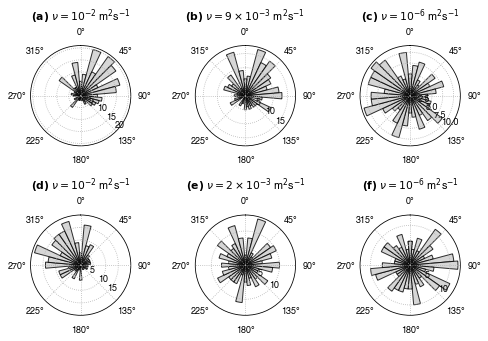

In [68]:
bin_size = 10

fig = plt.figure(figsize=(7,14))

font = {'family':'sans-serif',
        'sans-serif':['Helvetica'],
        'weight' : 'normal',
        'size'   : 9}

matplotlib.rc('font', **font)
plt.rc('axes', axisbelow=False)

ax1 = fig.add_subplot(631, projection='polar')
a , b = np.histogram(delta_L_one1, bins=np.arange(-5, 360+bin_size, bin_size))
centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
ax1.bar(centers, a, width=np.deg2rad(bin_size), bottom=0.0, alpha=0.8, color='0.8', edgecolor='k',label=r'$\nu=10^{-1}$')
ax1.set_theta_zero_location("N")
ax1.set_theta_direction(-1)
ax1.set_title(r'$\bf{(a)}$ $\nu=10^{-2}$ m$^{2}$s$^{-1}$',y=1.2)
ax1.set_rlabel_position(135)
ax1.grid(linestyle=':')

ax1 = fig.add_subplot(632, projection='polar')
a , b = np.histogram(delta_L_two1, bins=np.arange(-5, 360+bin_size, bin_size))
centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
ax1.bar(centers, a, width=np.deg2rad(bin_size), bottom=0.0, alpha=0.8,color='0.8', edgecolor='k',label=r'$\nu=10^{-2}$')
ax1.set_theta_zero_location("N")
ax1.set_theta_direction(-1)
ax1.set_title(r'$\bf{(b)}$ $\nu=9\times10^{-3}$ m$^{2}$s$^{-1}$',y=1.2)
ax1.set_rlabel_position(135)
ax1.grid(linestyle=':')

ax1 = fig.add_subplot(633, projection='polar')
a , b = np.histogram(delta_L_three1, bins=np.arange(-5, 360+bin_size, bin_size))
centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
ax1.bar(centers, a, width=np.deg2rad(bin_size), bottom=0.0, alpha=0.8,color='0.8', edgecolor='k',label=r'$\nu=10^{-3}$')
ax1.set_theta_zero_location("N")
ax1.set_theta_direction(-1)
ax1.set_title(r'$\bf{(c)}$ $\nu=10^{-6}$ m$^{2}$s$^{-1}$',y=1.2)
ax1.set_rlabel_position(135)
ax1.grid(linestyle=':')

ax1 = fig.add_subplot(634, projection='polar')
a , b = np.histogram(delta_L_one2, bins=np.arange(-5, 360+bin_size, bin_size))
centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
ax1.bar(centers, a, width=np.deg2rad(bin_size), bottom=0.0, alpha=0.8,color='0.8', edgecolor='k')
ax1.set_theta_zero_location("N")
ax1.set_theta_direction(-1)
ax1.set_title(r'$\bf{(d)}$ $\nu=10^{-2}$ m$^{2}$s$^{-1}$',y=1.2)
ax1.set_rlabel_position(135)
ax1.grid(linestyle=':')

ax1 = fig.add_subplot(635, projection='polar')
a , b = np.histogram(delta_L_two2, bins=np.arange(-5, 360+bin_size, bin_size))
centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
ax1.bar(centers, a, width=np.deg2rad(bin_size), bottom=0.0, alpha=0.8,color='0.8', edgecolor='k')
ax1.set_theta_zero_location("N")
ax1.set_theta_direction(-1)
ax1.set_title(r'$\bf{(e)}$ $\nu=2\times10^{-3}$ m$^{2}$s$^{-1}$',y=1.2)
ax1.set_rlabel_position(135)
ax1.grid(linestyle=':')

ax1 = fig.add_subplot(636, projection='polar')
a , b = np.histogram(delta_L_three2, bins=np.arange(-5, 360+bin_size, bin_size))
centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
ax1.bar(centers, a, width=np.deg2rad(bin_size), bottom=0.0, alpha=0.8,color='0.8', edgecolor='k')
ax1.set_theta_zero_location("N")
ax1.set_theta_direction(-1)
ax1.set_title(r'$\bf{(f)}$ $\nu=10^{-6}$ m$^{2}$s$^{-1}$',y=1.2)
ax1.set_rlabel_position(135)
ax1.grid(linestyle=':')

plt.tight_layout()

plt.savefig('/Users/jakecunningham/Documents/4YP/Figures/Wave_Roses_2002_TimeSeries.png', format='png', dpi=600,bbox_inches = "tight")